# Customer Analysis

In [24]:
# -------------------------------------------------------------------
# Setup cell — place this at the top of every analysis notebook
# -------------------------------------------------------------------
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import chi2_contingency

df = pd.read_csv("../datasets/customer_shopping_data_v10.csv")
sns.set_theme(style="whitegrid")

color1 = '#FF9E9D'  # Coral Pink
color2 = '#FFC785'  # Peach
color3 = '#FFF59D'  # Light Lemon
color4 = '#A0E6A6'  # Mint Green
color5 = '#87C8FF'  # Sky Blue
color6 = '#C4A2FF'  # Lavender

1. age ↔ total_spend <br>
Does the total spend increase with age?

In [4]:
# Method: OLS Linear Regression to test if age is associated with average spending per age

# Group by age and calculate average spending
age_group = df.groupby("age")["total_price"].mean().reset_index()

# Prepare X and y
X = age_group["age"]
y = age_group["total_price"]

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Print interpretation of significance
p_value = model.pvalues["age"]

if p_value < 0.05:
    print("✅ Significant relationship: Age is associated with average spending per age.")
else:
    print("❌ No significant relationship between age and average spending per age.")


                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9132
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.344
Time:                        08:25:35   Log-Likelihood:                -306.43
No. Observations:                  52   AIC:                             616.9
Df Residuals:                      50   BIC:                             620.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2493.8585     38.027     65.581      0.0

2. age ↔ transaction_count <br>
Do younger or older customers shop more frequently?

In [5]:
# Group by age and count transactions
age_txn = (
    df.groupby("age")
      .size()
      .reset_index(name="transaction_count")
)

# Display the counts to see which ages shop most
print(age_txn)

# Prepare X and y for regression
X = age_txn["age"]
y = age_txn["transaction_count"]

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Interpret significance
p_value = model.pvalues["age"]

if p_value < 0.05:
    print("✅ Significant relationship: Age is associated with transaction frequency.")
else:
    print("❌ No significant relationship between age and transaction frequency.")

    age  transaction_count
0    18               1844
1    19               1936
2    20               1844
3    21               1947
4    22               2051
5    23               1897
6    24               1977
7    25               1863
8    26               1896
9    27               1950
10   28               1953
11   29               1885
12   30               1981
13   31               1866
14   32               1891
15   33               1913
16   34               1883
17   35               1841
18   36               1954
19   37               2057
20   38               1954
21   39               1947
22   40               1960
23   41               1892
24   42               1892
25   43               2000
26   44               1904
27   45               1876
28   46               1911
29   47               1880
30   48               1955
31   49               1883
32   50               1873
33   51               1993
34   52               1945
35   53               1903
3

3. gender ↔ total_spend <br>
Is there a difference in spending levels between men and women?

In [20]:
# 1. Customer-level total spend
customer_spend = (
    df.groupby(['customer_id', 'gender'])['total_price']
      .sum()
      .reset_index(name='total_spend')
)
customer_spend.groupby('gender')['total_spend'].describe()


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,59482.0,2525.253623,4226.617822,5.23,136.35,600.17,2700.72,26250.0
Male,39975.0,2534.050237,4216.352329,5.23,130.75,600.17,2700.72,26250.0


                            OLS Regression Results                            
Dep. Variable:            total_spend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1038
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.747
Time:                        09:10:36   Log-Likelihood:            -9.7141e+05
No. Observations:               99457   AIC:                         1.943e+06
Df Residuals:                   99455   BIC:                         1.943e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2525.2536     17.31

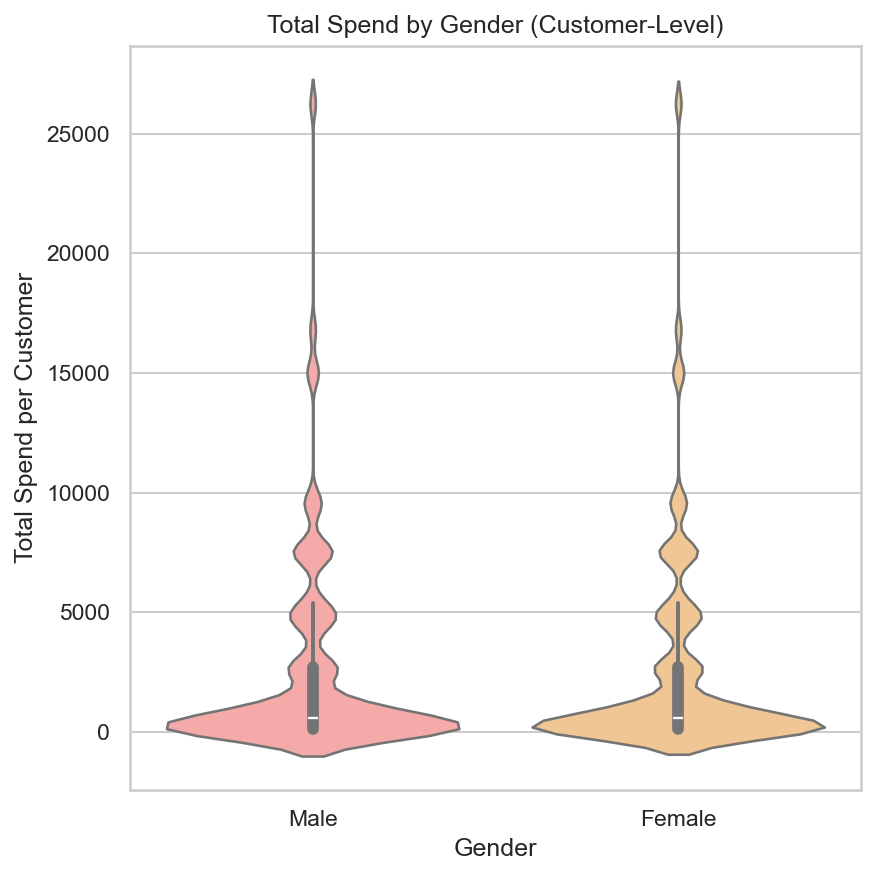

In [23]:
# 1. Customer-level total spend
customer_spend = (
    df.groupby(['customer_id', 'gender'])['total_price']
      .sum()
      .reset_index(name='total_spend')
)

# 2. OLS regression
model = smf.ols('total_spend ~ C(gender)', data=customer_spend).fit()

# Print regression summary
print(model.summary())

# Interpret significance
p_value = model.pvalues['C(gender)[T.Male]']

if p_value < 0.05:
    print("✅ Significant difference: Gender is associated with total spending.")
else:
    print("❌ No significant difference in total spending between genders.")

# 3. Violin plot
plt.figure(figsize=(6,6), dpi=150)
sns.violinplot(
    x='gender',
    y='total_spend',
    hue='gender',
    data=customer_spend,
    palette={'Male': color1, 'Female': color2},
    inner='box'   # Show median and quartiles
)
plt.xlabel("Gender")
plt.ylabel("Total Spend per Customer")
plt.title("Total Spend by Gender (Customer-Level)")
plt.tight_layout()
plt.show()

6. gender ↔ category <br>
Do product category preferences vary by gender?

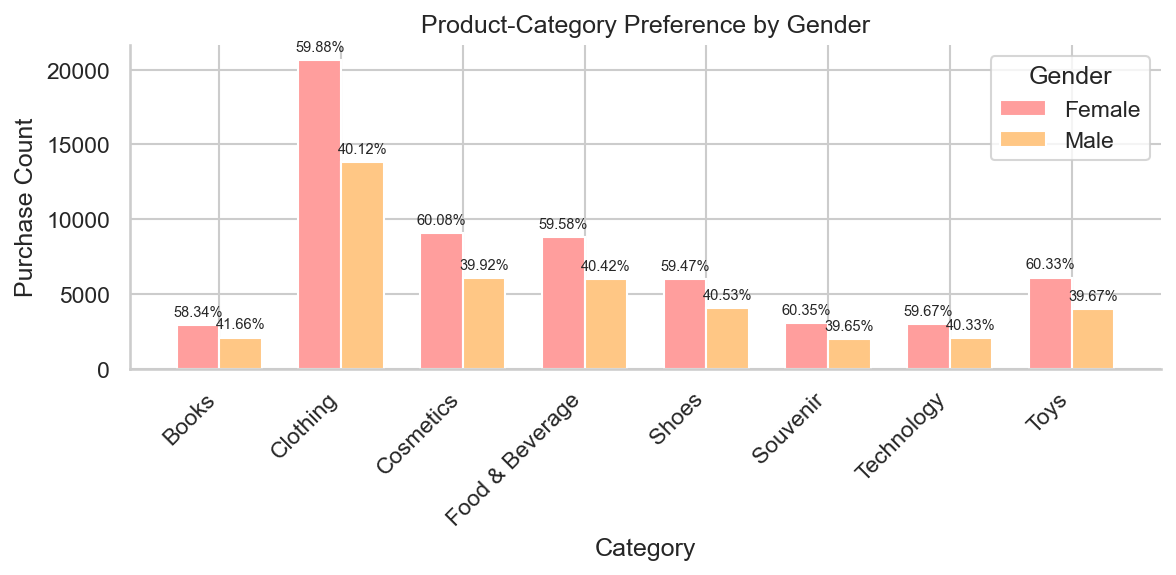


Observed counts:
gender           Female   Male
category                      
Books              2906   2075
Clothing          20652  13835
Cosmetics          9070   6027
Food & Beverage    8804   5972
Shoes              5967   4067
Souvenir           3017   1982
Technology         2981   2015
Toys               6085   4002

Expected counts under H0:
gender             Female      Male
category                           
Books             2978.97   2002.03
Clothing         20625.55  13861.45
Cosmetics         9029.03   6067.97
Food & Beverage   8837.05   5938.95
Shoes             6001.01   4032.99
Souvenir          2989.74   2009.26
Technology        2987.95   2008.05
Toys              6032.71   4054.29
χ² = 7.5679  (df=7)   p = 0.3722
At 95 % confidence, no significant gender effect on category preference.


In [18]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS 6: Do product-category preferences vary by gender?  ║
# ╚══════════════════════════════════════════════════════════════╝
ct = pd.crosstab(df["category"], df["gender"])
cats    = ct.index.tolist()
genders = ["Female", "Male"]
gender_colors = {"Female": color1, "Male": color2}
x       = np.arange(len(cats))
width   = 0.35

fig, ax = plt.subplots(figsize=(8,4), dpi=150)
for i, g in enumerate(genders):
    counts = ct[g].values
    barpos = x + (i-0.5)*width
    ax.bar(barpos, counts, width=width,
           color=gender_colors[g], label=g)
    pct = (counts / ct.sum(axis=1).values) * 100
    for j,(c,pcent) in enumerate(zip(counts,pct)):
        ax.text(barpos[j], c+max(ct.values.max()*0.02,1),
                f"{pcent:.2f}%", ha="center", va="bottom", fontsize=7)

ax.set_xticks(x); ax.set_xticklabels(cats, rotation=45, ha="right")
ax.set_ylabel("Purchase Count")
ax.set_xlabel("Category")
ax.set_title("Product-Category Preference by Gender")
ax.legend(title="Gender")
sns.despine()
plt.tight_layout()
plt.savefig("dataset_customer_analysis_figures/gender_category_6.png", dpi=150)
plt.show()

chi2,p,dof,exp = stats.chi2_contingency(ct)

# Convert expected array to DataFrame with same labels
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

print("\nObserved counts:")
print(ct)

print("\nExpected counts under H0:")
print(expected_df.round(2))   # round to 2 decimals

print(f"χ² = {chi2:.4f}  (df={dof})   p = {p:.4f}")
print("At 95 % confidence, category preference **differs** by gender."
      if p<0.05 else
      "At 95 % confidence, no significant gender effect on category preference.")


7. age_group ↔ category <br>
Do product category preferences change significantly by age group

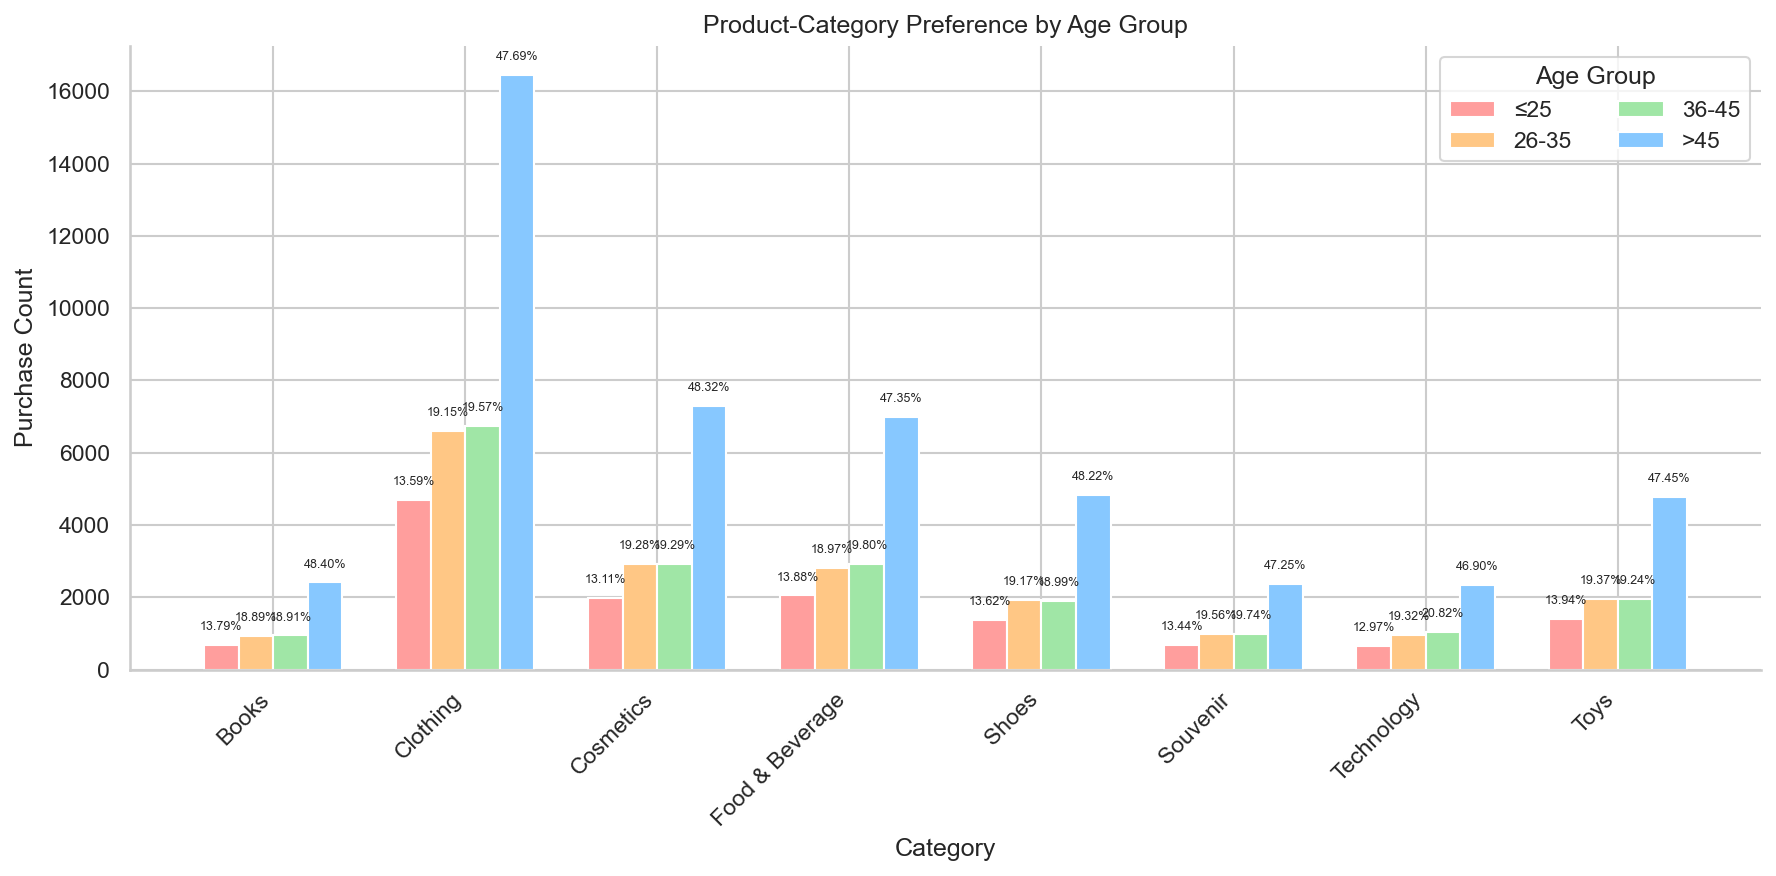


Observed counts:
age_group         ≤25  26-35  36-45    >45
category                                  
Books             687    941    942   2411
Clothing         4686   6605   6749  16447
Cosmetics        1979   2911   2912   7295
Food & Beverage  2051   2803   2925   6997
Shoes            1367   1924   1905   4838
Souvenir          672    978    987   2362
Technology        648    965   1040   2343
Toys             1406   1954   1941   4786

Expected counts under H0:
age_group            ≤25    26-35    36-45       >45
category                                            
Books             675.91   955.61   971.64   2377.84
Clothing         4679.78  6616.39  6727.35  16463.48
Cosmetics        2048.62  2896.39  2944.96   7207.04
Food & Beverage  2005.06  2834.80  2882.34   7053.80
Shoes            1361.58  1925.04  1957.32   4790.05
Souvenir          678.35   959.07   975.15   2386.43
Technology        677.94   958.49   974.57   2385.00
Toys             1368.77  1935.21  1967.66   481

In [20]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS 7: Do category preferences change by age group?     ║
# ╚══════════════════════════════════════════════════════════════╝
age_bins  = [0,25,35,45,120]
age_labels= ["≤25","26-35","36-45",">45"]
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=False)

ct = pd.crosstab(df["category"], df["age_group"])
cats      = ct.index.tolist()
groups    = age_labels
x         = np.arange(len(cats))
width     = 0.18
group_colors = ["#FF9E9D","#FFC785","#A0E6A6","#87C8FF"]

fig, ax = plt.subplots(figsize=(12,6), dpi=150)
for i,(grp,color) in enumerate(zip(groups,group_colors)):
    counts = ct[grp].values
    barpos = x + (i - (len(groups)-1)/2)*width
    ax.bar(barpos, counts, width=width,
           color=color, label=grp)
    pct = (counts / ct.sum(axis=1).values) * 100
    for j,(c,pcent) in enumerate(zip(counts,pct)):
        ax.text(barpos[j], c+max(ct.values.max()*0.02,1),
                f"{pcent:.2f}%",
                ha="center", va="bottom", fontsize=6)

ax.set_xticks(x)
ax.set_xticklabels(cats, rotation=45, ha="right")
ax.set_ylabel("Purchase Count")
ax.set_xlabel("Category")
ax.set_title("Product-Category Preference by Age Group")
ax.legend(title="Age Group", ncol=2)
sns.despine()
plt.tight_layout()
plt.savefig("dataset_customer_analysis_figures/age_group_category_7.png", dpi=150)
plt.show()

chi2,p,dof,exp = stats.chi2_contingency(ct)

# Convert expected array to DataFrame with same labels
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

print("\nObserved counts:")
print(ct)

print("\nExpected counts under H0:")
print(expected_df.round(2))   # round to 2 decimals

print(f"χ² = {chi2:.4f}  (df={dof})   p = {p:.4f}")
print("At 95 % confidence, category preference **varies** across age groups."
      if p<0.05 else
      "At 95 % confidence, no significant age-group effect on category preference.")

8. gender ↔ shopping_mall <br>
Does the distribution of shoppers across shopping malls differ by gender?

In [25]:
# Contingency table: Gender vs Shopping Mall
contingency_table = pd.crosstab(
    df["gender"],
    df["shopping_mall"]
)

print("Contingency Table:")
print(contingency_table)

# Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.4f}")

# Interpretation
if p < 0.05:
    print("✅ Significant association: Shopping mall preferences differ by gender.")
else:
    print("❌ No significant association between gender and shopping mall preference.")


Contingency Table:
shopping_mall  Cevahir AVM  Emaar Square Mall  Forum Istanbul  Istinye Park  \
gender                                                                        
Female                2940               2842            3016          5874   
Male                  2051               1969            1931          3907   

shopping_mall  Kanyon  Mall of Istanbul  Metrocity  Metropol AVM  \
gender                                                             
Female          11906             11902       8941          6144   
Male             7917              8041       6070          4017   

shopping_mall  Viaport Outlet  Zorlu Center  
gender                                       
Female                   2949          2968  
Male                     1965          2107  

Chi-Square Test Results:
Chi2 statistic = 12.45
Degrees of freedom = 9
p-value = 0.1893
❌ No significant association between gender and shopping mall preference.
